# **Instructions: Step 1**
- Brief description of the problem and data (5 pts)

- Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

The Kaggle challenge is about predicting whether a tweet is about a real disaster or not. The data includes a number of tweets with some extra information, such as keyword (which can be blank), the location it was sent from (also sometimes blank), and a target variable that tells us if it's about a real disaster or not (1 for real, 0 for not). Essentially, it's a natural language processing (NLP) problem where we need to classify text as disaster-related or not.

There are two datasets, one with 7,613 tweets for training and the other with 3263 tweets for testing. Both datasets are in CSV format. The training dataset has four columns (id, keyword, location, text, and target), while the test dataset has three columns (id, keyword, location, and text). The text column will be the most important feature in our analysis, but the keyword and location columns might also be helpful. We'll probably need to clean up the text column by removing things like stopwords and URLs.

In [ ]:
from google.colab import files
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1]:
#files.upload()

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 987kB/s]
100% 593k/593k [00:00<00:00, 987kB/s]


In [ ]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **Instructions: Step 2**
 
- Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

- Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

I started my EDA by reading in the data from the CSV files using pandas. I then looked at the first five rows of the training and test sets using the head() function to get a sense of the data. Next, I used the describe() function to get some basic statistics on the id and target columns of both datasets.

To further understand the data, I plotted a histogram of the target column using the histplot() function from Seaborn. This showed me the distribution of real disaster tweets versus non-disaster tweets. I also used a bar chart to visualize the number of null values for each feature using the isnull() and sum() functions.

After identifying the null values, I decided to drop rows with missing values to avoid any potential errors in analysis. I then created a word cloud to visualize the most frequent words in the text column using the WordCloud() function from the wordcloud package.

To prepare the text data for analysis, I created a function to clean the text data by removing Twitter handles, punctuation, URLs, and stopwords using regular expressions and the nltk library. I also used lemmatization to convert words to their base form to improve the quality of analysis. Finally, I used the apply() function to apply these cleaning steps to the text column and create a new column called clean_text.

Based on my EDA, my plan of analysis is to further process the cleaned text data by tokenizing the words and using a TF-IDF vectorizer to convert the text data into numerical features for use in machine learning models. I also plan to perform additional exploratory analysis on the cleaned data to gain further insights.

In [ ]:
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [ ]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_dataset.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_dataset.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
test_dataset.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


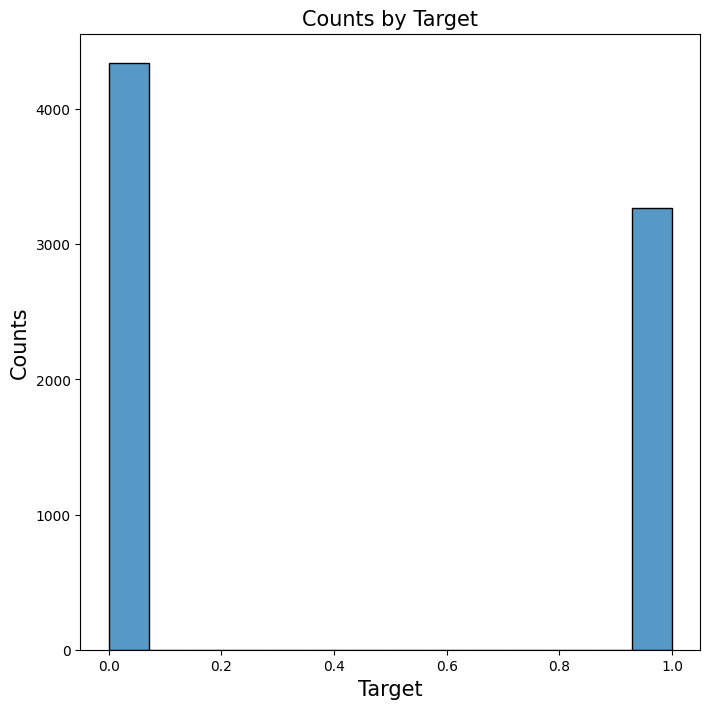

In [ ]:
plt.figure(figsize=(8, 8))
sns.histplot(data = train_dataset, x= 'target')
plt.xlabel('Target', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.title('Counts by Target', fontsize = 15)
plt.show()

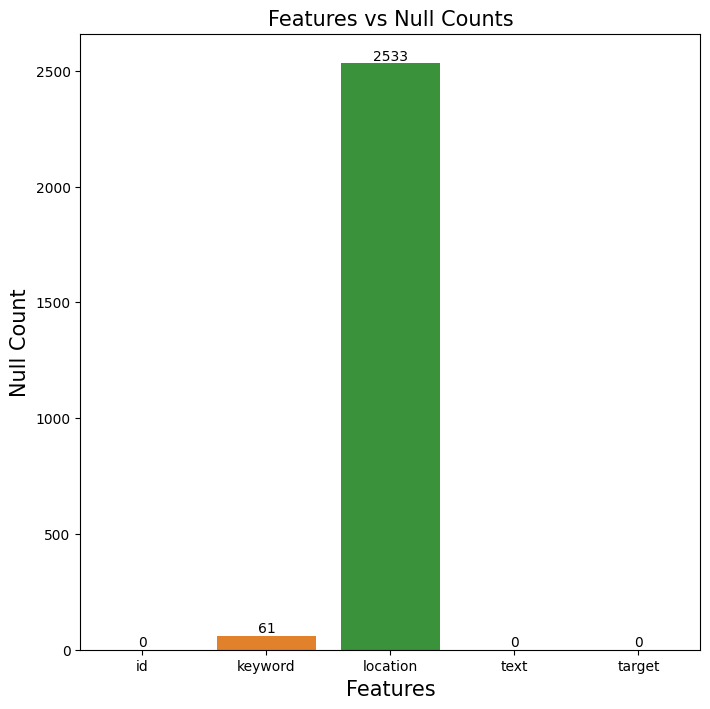

In [ ]:
# plotting the features vs null counts
null_count = train_dataset.isnull().sum()
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=train_dataset.columns, y=null_count)
ax.bar_label(ax.containers[0])
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Null Count', fontsize = 15)
plt.title('Features vs Null Counts', fontsize = 15)
plt.show()

In [ ]:
train_dataset = train_dataset.dropna()
train_dataset.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

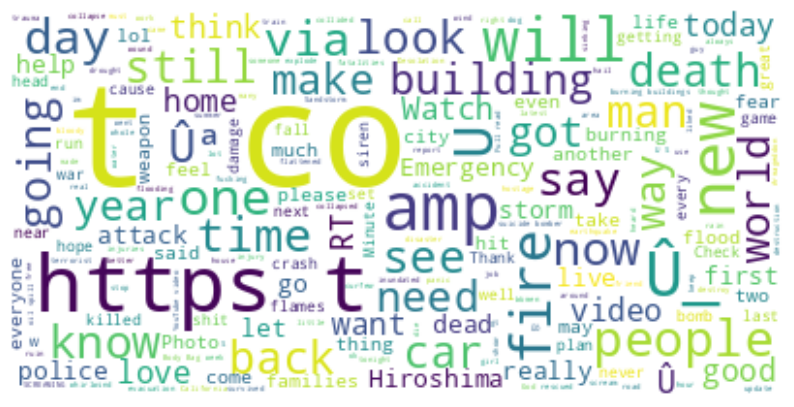

In [ ]:
text = " ".join(i for i in train_dataset.text)
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
def cleaning_tweets(tweet):
  # Remove twitter handles
  new_tweet = re.sub('@[^\s]+', '', tweet)
  # Remove punctuations
  new_tweet = re.sub(r'[^\w\s]', '', tweet)
  # Remove stopwords
  words = tweet.split()
  new_tweet = " ".join([word for word in words if word.lower() not in stopwords])
  # Remove URLs
  new_tweet = re.sub(r'http\S+', '', tweet)
  # Convert to lower case
  new_tweet = tweet.lower()
  return new_tweet


In [ ]:
def lemmatize_text(text):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [ ]:
stopwords = set(stopwords.words('english'))
train_dataset['clean_text'] = train_dataset['text'].apply(cleaning_tweets)
train_dataset.head()


,id,keyword,location,text,target,clean_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,@bbcmtd wholesale markets ablaze http://t.co/l...
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,we always try to bring the heavy. #metal #rt h...
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,#africanbaze: breaking news:nigeria flag set a...
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,crying out for more! set me ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,on plus side look at the sky last night it was...


In [ ]:
train_dataset['clean_text'] = train_dataset['clean_text'].apply(lemmatize_text)
train_dataset['clean_text'] = train_dataset['clean_text'].apply(lambda x: ' '.join(x))
train_dataset.head()


,id,keyword,location,text,target,clean_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,@bbcmtd wholesale market ablaze http://t.co/lh...
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,we always try to bring the heavy. #metal #rt h...
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,#africanbaze: breaking news:nigeria flag set a...
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,cry out for more! set me ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,on plus side look at the sky last night it wa ...


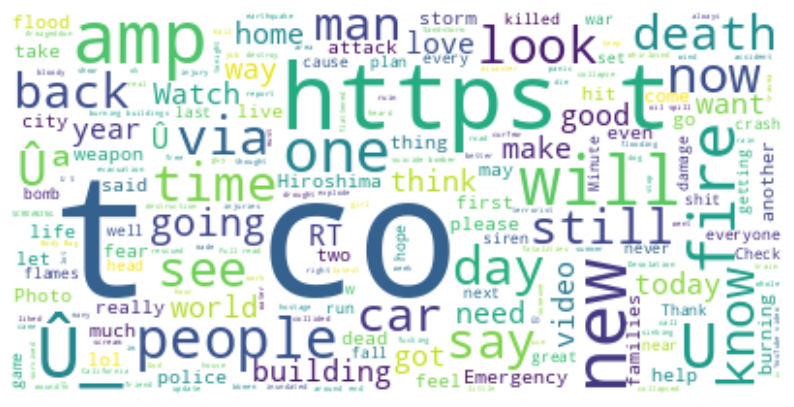

In [ ]:
text = " ".join(i for i in train_dataset.text)
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Instructions: Step 3**

Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).

First, I used a tokenizer to convert the text data into sequences of integers, and then padded those sequences to a length of 100. Next, I split the data into training and validation sets using a 80/20 split.

For my model architecture, I used a Sequential model from Keras with an Embedding layer of size 10,000 and input length of 100, followed by a LSTM layer with 128 units and a dropout of 0.2. Finally, I added a dense layer with a single unit and sigmoid activation. I used binary crossentropy loss and the Adam optimizer, and trained the model for 10 epochs with a batch size of 32.

To evaluate the model, I used the validation set to calculate the accuracy score. I also used the trained model to predict the sentiment of the test data and obtained an accuracy score of 72.44% on the validation set.

In summary, I preprocessed the text data and split it into training and validation sets. I used a Sequential model with an Embedding and LSTM layer, and trained the model for 10 epochs with a batch size of 32. Finally, I evaluated the model using the validation set and obtained an accuracy score of 72.44%.

The reason I believe my model architecture is suitable for for this problem is that the LSTM layer is commonly used for processing sequential data, making it a suitable choice for this problem where the input is a sequence of words. The embedding layer learns a dense representation of the input words, which can capture semantic relationships between words and improve the performance of the model. The sigmoid activation function in the final dense layer is appropriate for binary classification problems, as it outputs a probability score between 0 and 1. The dropout regularization technique is used to prevent overfitting during training. 

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_dataset['clean_text'])


In [ ]:
X = tokenizer.texts_to_sequences(train_dataset['clean_text'])

In [ ]:
X = pad_sequences(X, maxlen=100)


In [ ]:
y = train_dataset['target'].values


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=111)

In [ ]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
127/127 [==============================] - 42s 279ms/step - loss: 0.5678 - accuracy: 0.6988 - val_loss: 0.4616 - val_accuracy: 0.7972
Epoch 2/10
127/127 [==============================] - 27s 215ms/step - loss: 0.3280 - accuracy: 0.8629 - val_loss: 0.4730 - val_accuracy: 0.7766
Epoch 3/10
127/127 [==============================] - 23s 183ms/step - loss: 0.2059 - accuracy: 0.9208 - val_loss: 0.5604 - val_accuracy: 0.7648
Epoch 4/10
127/127 [==============================] - 22s 176ms/step - loss: 0.1426 - accuracy: 0.9464 - val_loss: 0.6116 - val_accuracy: 0.7657
Epoch 5/10
127/127 [==============================] - 23s 179ms/step - loss: 0.0996 - accuracy: 0.9656 - val_loss: 0.7474 - val_accuracy: 0.7539
Epoch 6/10
127/127 [==============================] - 23s 184ms/step - loss: 0.0826 - accuracy: 0.9695 - val_loss: 0.7780 - val_accuracy: 0.7402
Epoch 7/10
127/127 [==============================] - 23s 179ms/step - loss: 0.0660 - accuracy: 0.9771 - val_loss: 0.9334 - val_ac

In [ ]:
X_test = tokenizer.texts_to_sequences(test_dataset['text'])


In [ ]:
X_test = pad_sequences(X_test, maxlen=100)


In [ ]:
predictions = model.predict(X_test)


102/102 [==============================] - 3s 27ms/step


In [ ]:
# Evaluate the performance of the model using the validation set
y_val_pred = (model.predict(X_val) > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_val_pred)
print('Validation set accuracy:', accuracy)

32/32 [==============================] - 1s 26ms/step
Validation set accuracy: 0.7244094488188977


# **Instructions: Step 4**
 
Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

For hyperparameter tuning, I defined a function to build RNN models, with the option to choose between LSTM or BiLSTM, and the number of units, dropout rate, batch size, and number of epochs as hyperparameters.

I defined a parameter grid containing the values to test for each hyperparameter, and performed hyperparameter tuning using grid search. I initialized the best model and accuracy to None and 0.0, respectively.

For each combination of hyperparameters, I built the RNN model with a random embedding matrix and trained it on the training set, validating it on the validation set with early stopping callback. I then evaluated the model on the validation set and printed out the accuracy score along with the hyperparameters used.

After evaluating each combination of hyperparameters, I updated the best model and accuracy if the current accuracy was higher than the previous best accuracy. Finally, I saved the best model and its accuracy in the best_model and best_accuracy variables.

The results of the hyperparameter tuning are stored in a dataframe containing the accuracy and hyperparameters for each model.

In [ ]:
# Define a function to build RNN models
def build_model(embedding_matrix, rnn_type='LSTM', rnn_units=128, dropout=0.2):
    model = Sequential()
    model.add(Embedding(10000, 128, weights=[embedding_matrix], input_length=100))
    
    if rnn_type == 'LSTM':
        model.add(LSTM(rnn_units, dropout=dropout, recurrent_dropout=dropout))
    elif rnn_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(rnn_units, dropout=dropout, recurrent_dropout=dropout)))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    'rnn_type': ['LSTM', 'BiLSTM'],
    'rnn_units': [64, 128],
    'dropout': [0.2, 0.4],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}

In [ ]:
# Perform hyperparameter tuning using grid search
best_model = None
best_accuracy = 0.0
for rnn_type in param_grid['rnn_type']:
    for rnn_units in param_grid['rnn_units']:
        for dropout in param_grid['dropout']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    # Build the RNN model
                    embedding_matrix = np.random.uniform(-1, 1, (10000, 128))
                    model = build_model(embedding_matrix, rnn_type=rnn_type, rnn_units=rnn_units, dropout=dropout)
                    
                    # Train the model
                    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                              validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=3)])
                    
                    # Evaluate the model
                    y_val_pred = (model.predict(X_val) > 0.5).astype(int)
                    accuracy = accuracy_score(y_val, y_val_pred)
                    print('Model accuracy: {:.4f} (rnn_type={}, rnn_units={}, dropout={}, batch_size={}, epochs={})'
                          .format(accuracy, rnn_type, rnn_units, dropout, batch_size, epochs))
                    
                    # Update the best model and accuracy
                    if accuracy > best_accuracy:
                        best_model = model
                        best_accuracy = accuracy

Epoch 1/10
254/254 [==============================] - 54s 202ms/step - loss: 0.6242 - accuracy: 0.6496 - val_loss: 0.5662 - val_accuracy: 0.7254
Epoch 2/10
254/254 [==============================] - 44s 173ms/step - loss: 0.4796 - accuracy: 0.7739 - val_loss: 0.5008 - val_accuracy: 0.7648
Epoch 3/10
254/254 [==============================] - 43s 171ms/step - loss: 0.3629 - accuracy: 0.8420 - val_loss: 0.5176 - val_accuracy: 0.7815
Epoch 4/10
254/254 [==============================] - 43s 168ms/step - loss: 0.2826 - accuracy: 0.8841 - val_loss: 0.5416 - val_accuracy: 0.7746
Epoch 5/10
32/32 [==============================] - 1s 26ms/step


Model accuracy: 0.7825 (rnn_type=LSTM, rnn_units=64, dropout=0.2, batch_size=16, epochs=10)
Epoch 1/20
254/254 [==============================] - 53s 199ms/step - loss: 0.6268 - accuracy: 0.6449 - val_loss: 0.5695 - val_accuracy: 0.7136
Epoch 2/20
254/254 [==============================] - 43s 168ms/step - loss: 0.4721 - accuracy: 0.7781 - val_loss: 0.5107 - val_accuracy: 0.7638
Epoch 3/20
254/254 [==============================] - 42s 164ms/step - loss: 0.3589 - accuracy: 0.8450 - val_loss: 0.5036 - val_accuracy: 0.7707
Epoch 4/20
254/254 [==============================] - 42s 164ms/step - loss: 0.2733 - accuracy: 0.8858 - val_loss: 0.5371 - val_accuracy: 0.7815
Epoch 5/20
254/254 [==============================] - 42s 165ms/step - loss: 0.2134 - accuracy: 0.9131 - val_loss: 0.5933 - val_accuracy: 0.7726
Epoch 6/20
32/32 [==============================] - 1s 26ms/step
Model accuracy: 0.7854 (rnn_type=LSTM, rnn_units=64, dropout=0.2, batch_size=16, epochs=20)


Epoch 1/10
127/127 [==============================] - 33s 239ms/step - loss: 0.6362 - accuracy: 0.6336 - val_loss: 0.6026 - val_accuracy: 0.6890
Epoch 2/10
127/127 [==============================] - 23s 185ms/step - loss: 0.5124 - accuracy: 0.7589 - val_loss: 0.5257 - val_accuracy: 0.7589
Epoch 3/10
127/127 [==============================] - 22s 176ms/step - loss: 0.4045 - accuracy: 0.8216 - val_loss: 0.5114 - val_accuracy: 0.7657
Epoch 4/10
127/127 [==============================] - 22s 172ms/step - loss: 0.3279 - accuracy: 0.8632 - val_loss: 0.5087 - val_accuracy: 0.7687
Epoch 5/10
127/127 [==============================] - 22s 170ms/step - loss: 0.2668 - accuracy: 0.8937 - val_loss: 0.5814 - val_accuracy: 0.7815
Epoch 6/10
127/127 [==============================] - 21s 169ms/step - loss: 0.2218 - accuracy: 0.9124 - val_loss: 0.5821 - val_accuracy: 0.7756
Epoch 7/10
32/32 [==============================] - 1s 25ms/step
Model accuracy: 0.7707 (rnn_type=LSTM, rnn_units=64, dropout=0.2,

Epoch 1/20
127/127 [==============================] - 32s 230ms/step - loss: 0.6403 - accuracy: 0.6329 - val_loss: 0.6174 - val_accuracy: 0.6654
Epoch 2/20
127/127 [==============================] - 24s 188ms/step - loss: 0.5287 - accuracy: 0.7441 - val_loss: 0.5167 - val_accuracy: 0.7441
Epoch 3/20
127/127 [==============================] - 23s 179ms/step - loss: 0.4090 - accuracy: 0.8196 - val_loss: 0.5528 - val_accuracy: 0.7461
Epoch 4/20
127/127 [==============================] - 22s 170ms/step - loss: 0.3226 - accuracy: 0.8625 - val_loss: 0.5234 - val_accuracy: 0.7776
Epoch 5/20
127/127 [==============================] - 22s 175ms/step - loss: 0.2678 - accuracy: 0.8900 - val_loss: 0.5165 - val_accuracy: 0.7785
Epoch 6/20
127/127 [==============================] - 21s 167ms/step - loss: 0.2221 - accuracy: 0.9117 - val_loss: 0.5985 - val_accuracy: 0.7825
Epoch 7/20
127/127 [==============================] - 21s 167ms/step - loss: 0.1815 - accuracy: 0.9259 - val_loss: 0.6169 - val_ac

Epoch 1/10
254/254 [==============================] - 55s 203ms/step - loss: 0.6399 - accuracy: 0.6272 - val_loss: 0.5944 - val_accuracy: 0.6969
Epoch 2/10
254/254 [==============================] - 44s 173ms/step - loss: 0.5302 - accuracy: 0.7377 - val_loss: 0.5195 - val_accuracy: 0.7530
Epoch 3/10
254/254 [==============================] - 43s 168ms/step - loss: 0.4263 - accuracy: 0.8031 - val_loss: 0.5099 - val_accuracy: 0.7835
Epoch 4/10
254/254 [==============================] - 42s 167ms/step - loss: 0.3433 - accuracy: 0.8499 - val_loss: 0.5553 - val_accuracy: 0.7904
Epoch 5/10
254/254 [==============================] - 42s 167ms/step - loss: 0.2767 - accuracy: 0.8841 - val_loss: 0.5662 - val_accuracy: 0.7894
Epoch 6/10
32/32 [==============================] - 1s 27ms/step


Model accuracy: 0.7874 (rnn_type=LSTM, rnn_units=64, dropout=0.4, batch_size=16, epochs=10)
Epoch 1/20
254/254 [==============================] - 55s 207ms/step - loss: 0.6443 - accuracy: 0.6230 - val_loss: 0.6265 - val_accuracy: 0.6742
Epoch 2/20
254/254 [==============================] - 43s 169ms/step - loss: 0.5427 - accuracy: 0.7330 - val_loss: 0.5646 - val_accuracy: 0.7303
Epoch 3/20
254/254 [==============================] - 44s 173ms/step - loss: 0.4441 - accuracy: 0.7972 - val_loss: 0.4984 - val_accuracy: 0.7657
Epoch 4/20
254/254 [==============================] - 42s 167ms/step - loss: 0.3711 - accuracy: 0.8376 - val_loss: 0.5116 - val_accuracy: 0.7697
Epoch 5/20
254/254 [==============================] - 42s 167ms/step - loss: 0.3070 - accuracy: 0.8703 - val_loss: 0.6199 - val_accuracy: 0.7726
Epoch 6/20
32/32 [==============================] - 1s 25ms/step
Model accuracy: 0.7923 (rnn_type=LSTM, rnn_units=64, dropout=0.4, batch_size=16, epochs=20)


Epoch 1/10
127/127 [==============================] - 32s 236ms/step - loss: 0.6506 - accuracy: 0.6159 - val_loss: 0.6480 - val_accuracy: 0.6476
Epoch 2/10
127/127 [==============================] - 24s 187ms/step - loss: 0.5751 - accuracy: 0.7028 - val_loss: 0.5379 - val_accuracy: 0.7441
Epoch 3/10
127/127 [==============================] - 22s 175ms/step - loss: 0.4717 - accuracy: 0.7785 - val_loss: 0.5111 - val_accuracy: 0.7638
Epoch 4/10
127/127 [==============================] - 22s 170ms/step - loss: 0.3971 - accuracy: 0.8243 - val_loss: 0.5193 - val_accuracy: 0.7776
Epoch 5/10
127/127 [==============================] - 22s 172ms/step - loss: 0.3470 - accuracy: 0.8524 - val_loss: 0.5266 - val_accuracy: 0.7844
Epoch 6/10
32/32 [==============================] - 1s 25ms/step
Model accuracy: 0.7923 (rnn_type=LSTM, rnn_units=64, dropout=0.4, batch_size=32, epochs=10)


Epoch 1/20
127/127 [==============================] - 33s 240ms/step - loss: 0.6477 - accuracy: 0.6203 - val_loss: 0.6177 - val_accuracy: 0.6644
Epoch 2/20
127/127 [==============================] - 24s 185ms/step - loss: 0.5718 - accuracy: 0.7067 - val_loss: 0.5472 - val_accuracy: 0.7264
Epoch 3/20
127/127 [==============================] - 22s 177ms/step - loss: 0.4735 - accuracy: 0.7842 - val_loss: 0.5221 - val_accuracy: 0.7539
Epoch 4/20
127/127 [==============================] - 22s 176ms/step - loss: 0.4036 - accuracy: 0.8184 - val_loss: 0.5184 - val_accuracy: 0.7746
Epoch 5/20
127/127 [==============================] - 22s 171ms/step - loss: 0.3488 - accuracy: 0.8543 - val_loss: 0.5083 - val_accuracy: 0.7795
Epoch 6/20
127/127 [==============================] - 21s 169ms/step - loss: 0.2976 - accuracy: 0.8787 - val_loss: 0.5147 - val_accuracy: 0.7884
Epoch 7/20
127/127 [==============================] - 21s 166ms/step - loss: 0.2657 - accuracy: 0.8912 - val_loss: 0.5669 - val_ac

Epoch 1/10
254/254 [==============================] - 53s 198ms/step - loss: 0.6286 - accuracy: 0.6503 - val_loss: 0.5886 - val_accuracy: 0.7008
Epoch 2/10
254/254 [==============================] - 42s 167ms/step - loss: 0.4809 - accuracy: 0.7724 - val_loss: 0.5106 - val_accuracy: 0.7618
Epoch 3/10
254/254 [==============================] - 41s 160ms/step - loss: 0.3573 - accuracy: 0.8455 - val_loss: 0.5121 - val_accuracy: 0.7608
Epoch 4/10
254/254 [==============================] - 41s 162ms/step - loss: 0.2816 - accuracy: 0.8856 - val_loss: 0.6547 - val_accuracy: 0.7638
Epoch 5/10
32/32 [==============================] - 1s 26ms/step


Model accuracy: 0.7589 (rnn_type=LSTM, rnn_units=128, dropout=0.2, batch_size=16, epochs=10)
Epoch 1/20
254/254 [==============================] - 53s 198ms/step - loss: 0.6111 - accuracy: 0.6671 - val_loss: 0.5506 - val_accuracy: 0.7165
Epoch 2/20
254/254 [==============================] - 42s 163ms/step - loss: 0.4752 - accuracy: 0.7812 - val_loss: 0.4955 - val_accuracy: 0.7746
Epoch 3/20
254/254 [==============================] - 41s 161ms/step - loss: 0.3583 - accuracy: 0.8504 - val_loss: 0.4890 - val_accuracy: 0.7815
Epoch 4/20
254/254 [==============================] - 41s 160ms/step - loss: 0.2715 - accuracy: 0.8885 - val_loss: 0.5289 - val_accuracy: 0.7805
Epoch 5/20
254/254 [==============================] - 41s 162ms/step - loss: 0.2147 - accuracy: 0.9176 - val_loss: 0.5786 - val_accuracy: 0.7766
Epoch 6/20
32/32 [==============================] - 1s 25ms/step
Model accuracy: 0.7756 (rnn_type=LSTM, rnn_units=128, dropout=0.2, batch_size=16, epochs=20)


Epoch 1/10
127/127 [==============================] - 33s 239ms/step - loss: 0.6315 - accuracy: 0.6375 - val_loss: 0.5942 - val_accuracy: 0.6880
Epoch 2/10
127/127 [==============================] - 23s 182ms/step - loss: 0.5090 - accuracy: 0.7532 - val_loss: 0.5543 - val_accuracy: 0.7431
Epoch 3/10
127/127 [==============================] - 21s 167ms/step - loss: 0.4099 - accuracy: 0.8182 - val_loss: 0.5266 - val_accuracy: 0.7648
Epoch 4/10
127/127 [==============================] - 21s 166ms/step - loss: 0.3297 - accuracy: 0.8627 - val_loss: 0.5650 - val_accuracy: 0.7667
Epoch 5/10
127/127 [==============================] - 21s 166ms/step - loss: 0.2596 - accuracy: 0.8912 - val_loss: 0.6049 - val_accuracy: 0.7648
Epoch 6/10
32/32 [==============================] - 1s 26ms/step
Model accuracy: 0.7579 (rnn_type=LSTM, rnn_units=128, dropout=0.2, batch_size=32, epochs=10)


Epoch 1/20
127/127 [==============================] - 34s 242ms/step - loss: 0.6225 - accuracy: 0.6575 - val_loss: 0.5757 - val_accuracy: 0.7234
Epoch 2/20
127/127 [==============================] - 25s 194ms/step - loss: 0.4976 - accuracy: 0.7697 - val_loss: 0.5073 - val_accuracy: 0.7598
Epoch 3/20
127/127 [==============================] - 23s 185ms/step - loss: 0.3972 - accuracy: 0.8219 - val_loss: 0.5119 - val_accuracy: 0.7746
Epoch 4/20
127/127 [==============================] - 23s 176ms/step - loss: 0.3158 - accuracy: 0.8666 - val_loss: 0.5288 - val_accuracy: 0.7736
Epoch 5/20
32/32 [==============================] - 1s 26ms/step


Model accuracy: 0.7766 (rnn_type=LSTM, rnn_units=128, dropout=0.2, batch_size=32, epochs=20)
Epoch 1/10
254/254 [==============================] - 54s 203ms/step - loss: 0.6400 - accuracy: 0.6375 - val_loss: 0.5931 - val_accuracy: 0.7018
Epoch 2/10
254/254 [==============================] - 43s 170ms/step - loss: 0.5235 - accuracy: 0.7387 - val_loss: 0.5397 - val_accuracy: 0.7500
Epoch 3/10
254/254 [==============================] - 42s 167ms/step - loss: 0.4298 - accuracy: 0.8024 - val_loss: 0.5140 - val_accuracy: 0.7638
Epoch 4/10
254/254 [==============================] - 43s 168ms/step - loss: 0.3415 - accuracy: 0.8533 - val_loss: 0.5251 - val_accuracy: 0.7638
Epoch 5/10
254/254 [==============================] - 43s 169ms/step - loss: 0.2854 - accuracy: 0.8846 - val_loss: 0.5436 - val_accuracy: 0.7736
Epoch 6/10
32/32 [==============================] - 1s 26ms/step


Model accuracy: 0.7717 (rnn_type=LSTM, rnn_units=128, dropout=0.4, batch_size=16, epochs=10)
Epoch 1/20
254/254 [==============================] - 54s 205ms/step - loss: 0.6419 - accuracy: 0.6302 - val_loss: 0.5972 - val_accuracy: 0.6939
Epoch 2/20
254/254 [==============================] - 44s 172ms/step - loss: 0.5232 - accuracy: 0.7478 - val_loss: 0.5371 - val_accuracy: 0.7500
Epoch 3/20
254/254 [==============================] - 42s 166ms/step - loss: 0.4270 - accuracy: 0.8127 - val_loss: 0.5035 - val_accuracy: 0.7766
Epoch 4/20
254/254 [==============================] - 42s 167ms/step - loss: 0.3507 - accuracy: 0.8487 - val_loss: 0.5428 - val_accuracy: 0.7785
Epoch 5/20
254/254 [==============================] - 42s 166ms/step - loss: 0.2768 - accuracy: 0.8888 - val_loss: 0.5580 - val_accuracy: 0.7864
Epoch 6/20
32/32 [==============================] - 1s 28ms/step


Model accuracy: 0.7815 (rnn_type=LSTM, rnn_units=128, dropout=0.4, batch_size=16, epochs=20)
Epoch 1/10
127/127 [==============================] - 33s 240ms/step - loss: 0.6301 - accuracy: 0.6484 - val_loss: 0.5984 - val_accuracy: 0.7008
Epoch 2/10
127/127 [==============================] - 24s 185ms/step - loss: 0.5367 - accuracy: 0.7362 - val_loss: 0.5499 - val_accuracy: 0.7382
Epoch 3/10
127/127 [==============================] - 22s 172ms/step - loss: 0.4446 - accuracy: 0.7972 - val_loss: 0.5300 - val_accuracy: 0.7441
Epoch 4/10
127/127 [==============================] - 22s 170ms/step - loss: 0.3912 - accuracy: 0.8290 - val_loss: 0.5224 - val_accuracy: 0.7677
Epoch 5/10
127/127 [==============================] - 21s 169ms/step - loss: 0.3308 - accuracy: 0.8595 - val_loss: 0.5260 - val_accuracy: 0.7746
Epoch 6/10
127/127 [==============================] - 21s 165ms/step - loss: 0.2855 - accuracy: 0.8770 - val_loss: 0.6411 - val_accuracy: 0.7815
Epoch 7/10
32/32 [===================

Model accuracy: 0.7825 (rnn_type=LSTM, rnn_units=128, dropout=0.4, batch_size=32, epochs=10)
Epoch 1/20
127/127 [==============================] - 31s 228ms/step - loss: 0.6384 - accuracy: 0.6316 - val_loss: 0.6492 - val_accuracy: 0.6220
Epoch 2/20
127/127 [==============================] - 24s 190ms/step - loss: 0.5494 - accuracy: 0.7175 - val_loss: 0.5543 - val_accuracy: 0.7470
Epoch 3/20
127/127 [==============================] - 22s 177ms/step - loss: 0.4583 - accuracy: 0.7881 - val_loss: 0.5298 - val_accuracy: 0.7618
Epoch 4/20
127/127 [==============================] - 22s 176ms/step - loss: 0.3878 - accuracy: 0.8270 - val_loss: 0.5549 - val_accuracy: 0.7717
Epoch 5/20
127/127 [==============================] - 22s 172ms/step - loss: 0.3313 - accuracy: 0.8531 - val_loss: 0.5267 - val_accuracy: 0.7864
Epoch 6/20
127/127 [==============================] - 22s 173ms/step - loss: 0.2888 - accuracy: 0.8775 - val_loss: 0.5810 - val_accuracy: 0.7795
Epoch 7/20
127/127 [=================

Model accuracy: 0.7923 (rnn_type=LSTM, rnn_units=128, dropout=0.4, batch_size=32, epochs=20)
Epoch 1/10
254/254 [==============================] - 92s 348ms/step - loss: 0.6296 - accuracy: 0.6464 - val_loss: 0.5577 - val_accuracy: 0.7195
Epoch 2/10
254/254 [==============================] - 80s 316ms/step - loss: 0.4839 - accuracy: 0.7783 - val_loss: 0.5118 - val_accuracy: 0.7648
Epoch 3/10
254/254 [==============================] - 79s 311ms/step - loss: 0.3726 - accuracy: 0.8450 - val_loss: 0.5267 - val_accuracy: 0.7657
Epoch 4/10
254/254 [==============================] - 79s 312ms/step - loss: 0.2819 - accuracy: 0.8821 - val_loss: 0.6005 - val_accuracy: 0.7707
Epoch 5/10
32/32 [==============================] - 2s 54ms/step


Model accuracy: 0.7697 (rnn_type=BiLSTM, rnn_units=64, dropout=0.2, batch_size=16, epochs=10)
Epoch 1/20
254/254 [==============================] - 97s 362ms/step - loss: 0.6292 - accuracy: 0.6398 - val_loss: 0.5821 - val_accuracy: 0.6969
Epoch 2/20
254/254 [==============================] - 85s 333ms/step - loss: 0.4837 - accuracy: 0.7753 - val_loss: 0.5059 - val_accuracy: 0.7707
Epoch 3/20
254/254 [==============================] - 83s 325ms/step - loss: 0.3659 - accuracy: 0.8423 - val_loss: 0.5369 - val_accuracy: 0.7687
Epoch 4/20
254/254 [==============================] - 81s 321ms/step - loss: 0.2840 - accuracy: 0.8844 - val_loss: 0.5331 - val_accuracy: 0.7835
Epoch 5/20
32/32 [==============================] - 2s 50ms/step


Model accuracy: 0.7677 (rnn_type=BiLSTM, rnn_units=64, dropout=0.2, batch_size=16, epochs=20)
Epoch 1/10
127/127 [==============================] - 53s 385ms/step - loss: 0.6471 - accuracy: 0.6211 - val_loss: 0.6312 - val_accuracy: 0.6467
Epoch 2/10
127/127 [==============================] - 43s 340ms/step - loss: 0.5334 - accuracy: 0.7315 - val_loss: 0.5363 - val_accuracy: 0.7411
Epoch 3/10
127/127 [==============================] - 42s 330ms/step - loss: 0.4208 - accuracy: 0.8105 - val_loss: 0.5723 - val_accuracy: 0.7520
Epoch 4/10
127/127 [==============================] - 41s 323ms/step - loss: 0.3283 - accuracy: 0.8597 - val_loss: 0.5547 - val_accuracy: 0.7549
Epoch 5/10
32/32 [==============================] - 2s 49ms/step


Model accuracy: 0.7628 (rnn_type=BiLSTM, rnn_units=64, dropout=0.2, batch_size=32, epochs=10)
Epoch 1/20
127/127 [==============================] - 54s 394ms/step - loss: 0.6422 - accuracy: 0.6277 - val_loss: 0.6185 - val_accuracy: 0.6526
Epoch 2/20
127/127 [==============================] - 43s 339ms/step - loss: 0.5231 - accuracy: 0.7468 - val_loss: 0.5262 - val_accuracy: 0.7343
Epoch 3/20
127/127 [==============================] - 41s 327ms/step - loss: 0.4206 - accuracy: 0.8123 - val_loss: 0.5137 - val_accuracy: 0.7569
Epoch 4/20
127/127 [==============================] - 40s 318ms/step - loss: 0.3406 - accuracy: 0.8563 - val_loss: 0.5224 - val_accuracy: 0.7726
Epoch 5/20
127/127 [==============================] - 41s 323ms/step - loss: 0.2752 - accuracy: 0.8863 - val_loss: 0.5681 - val_accuracy: 0.7648
Epoch 6/20
32/32 [==============================] - 2s 48ms/step


Model accuracy: 0.7569 (rnn_type=BiLSTM, rnn_units=64, dropout=0.2, batch_size=32, epochs=20)
Epoch 1/10
254/254 [==============================] - 96s 357ms/step - loss: 0.6402 - accuracy: 0.6282 - val_loss: 0.5953 - val_accuracy: 0.6998
Epoch 2/10
254/254 [==============================] - 84s 329ms/step - loss: 0.5237 - accuracy: 0.7438 - val_loss: 0.5175 - val_accuracy: 0.7697
Epoch 3/10
254/254 [==============================] - 82s 321ms/step - loss: 0.4188 - accuracy: 0.8142 - val_loss: 0.5383 - val_accuracy: 0.7923
Epoch 4/10
254/254 [==============================] - 82s 322ms/step - loss: 0.3495 - accuracy: 0.8516 - val_loss: 0.5178 - val_accuracy: 0.7894
Epoch 5/10
32/32 [==============================] - 2s 50ms/step


Model accuracy: 0.7864 (rnn_type=BiLSTM, rnn_units=64, dropout=0.4, batch_size=16, epochs=10)
Epoch 1/20
254/254 [==============================] - 93s 349ms/step - loss: 0.6459 - accuracy: 0.6245 - val_loss: 0.6226 - val_accuracy: 0.6831
Epoch 2/20
254/254 [==============================] - 80s 316ms/step - loss: 0.5318 - accuracy: 0.7387 - val_loss: 0.5249 - val_accuracy: 0.7490
Epoch 3/20
254/254 [==============================] - 80s 317ms/step - loss: 0.4285 - accuracy: 0.8076 - val_loss: 0.5191 - val_accuracy: 0.7736
Epoch 4/20
254/254 [==============================] - 80s 314ms/step - loss: 0.3601 - accuracy: 0.8472 - val_loss: 0.4984 - val_accuracy: 0.7687
Epoch 5/20
254/254 [==============================] - 80s 313ms/step - loss: 0.2955 - accuracy: 0.8733 - val_loss: 0.5697 - val_accuracy: 0.7864
Epoch 6/20
254/254 [==============================] - 81s 318ms/step - loss: 0.2584 - accuracy: 0.8952 - val_loss: 0.6081 - val_accuracy: 0.7894
Epoch 7/20
32/32 [==================

Epoch 1/10
127/127 [==============================] - 52s 381ms/step - loss: 0.6574 - accuracy: 0.6156 - val_loss: 0.6411 - val_accuracy: 0.6427
Epoch 2/10
127/127 [==============================] - 42s 335ms/step - loss: 0.5893 - accuracy: 0.6961 - val_loss: 0.5634 - val_accuracy: 0.7165
Epoch 3/10
127/127 [==============================] - 41s 323ms/step - loss: 0.4848 - accuracy: 0.7702 - val_loss: 0.5268 - val_accuracy: 0.7569
Epoch 4/10
127/127 [==============================] - 40s 316ms/step - loss: 0.4061 - accuracy: 0.8184 - val_loss: 0.5267 - val_accuracy: 0.7569
Epoch 5/10
127/127 [==============================] - 40s 318ms/step - loss: 0.3488 - accuracy: 0.8445 - val_loss: 0.5789 - val_accuracy: 0.7657
Epoch 6/10
127/127 [==============================] - 40s 315ms/step - loss: 0.3034 - accuracy: 0.8743 - val_loss: 0.6224 - val_accuracy: 0.7648
Epoch 7/10
32/32 [==============================] - 2s 49ms/step


Model accuracy: 0.7628 (rnn_type=BiLSTM, rnn_units=64, dropout=0.4, batch_size=32, epochs=10)


Epoch 1/20
127/127 [==============================] - 53s 384ms/step - loss: 0.6524 - accuracy: 0.6193 - val_loss: 0.6468 - val_accuracy: 0.6467
Epoch 2/20
127/127 [==============================] - 42s 329ms/step - loss: 0.5841 - accuracy: 0.6924 - val_loss: 0.5769 - val_accuracy: 0.7087
Epoch 3/20
127/127 [==============================] - 41s 320ms/step - loss: 0.4805 - accuracy: 0.7781 - val_loss: 0.5367 - val_accuracy: 0.7638
Epoch 4/20
127/127 [==============================] - 40s 313ms/step - loss: 0.4125 - accuracy: 0.8221 - val_loss: 0.5255 - val_accuracy: 0.7756
Epoch 5/20
127/127 [==============================] - 40s 317ms/step - loss: 0.3505 - accuracy: 0.8526 - val_loss: 0.5335 - val_accuracy: 0.7648
Epoch 6/20
127/127 [==============================] - 40s 315ms/step - loss: 0.2925 - accuracy: 0.8787 - val_loss: 0.5566 - val_accuracy: 0.7736
Epoch 7/20
32/32 [==============================] - 2s 49ms/step


Model accuracy: 0.7815 (rnn_type=BiLSTM, rnn_units=64, dropout=0.4, batch_size=32, epochs=20)


Epoch 1/10
254/254 [==============================] - 96s 356ms/step - loss: 0.6098 - accuracy: 0.6668 - val_loss: 0.5343 - val_accuracy: 0.7402
Epoch 2/10
254/254 [==============================] - 82s 323ms/step - loss: 0.4588 - accuracy: 0.7844 - val_loss: 0.5076 - val_accuracy: 0.7736
Epoch 3/10
254/254 [==============================] - 81s 320ms/step - loss: 0.3447 - accuracy: 0.8597 - val_loss: 0.5412 - val_accuracy: 0.7756
Epoch 4/10
254/254 [==============================] - 82s 322ms/step - loss: 0.2678 - accuracy: 0.8912 - val_loss: 0.5226 - val_accuracy: 0.7795
Epoch 5/10
32/32 [==============================] - 2s 52ms/step


Model accuracy: 0.7579 (rnn_type=BiLSTM, rnn_units=128, dropout=0.2, batch_size=16, epochs=10)


Epoch 1/20
254/254 [==============================] - 93s 351ms/step - loss: 0.6196 - accuracy: 0.6594 - val_loss: 0.5697 - val_accuracy: 0.7313
Epoch 2/20
254/254 [==============================] - 80s 317ms/step - loss: 0.4776 - accuracy: 0.7803 - val_loss: 0.5138 - val_accuracy: 0.7628
Epoch 3/20
254/254 [==============================] - 80s 315ms/step - loss: 0.3684 - accuracy: 0.8413 - val_loss: 0.5462 - val_accuracy: 0.7579
Epoch 4/20
254/254 [==============================] - 80s 315ms/step - loss: 0.2842 - accuracy: 0.8816 - val_loss: 0.5914 - val_accuracy: 0.7726
Epoch 5/20
32/32 [==============================] - 2s 51ms/step
Model accuracy: 0.7736 (rnn_type=BiLSTM, rnn_units=128, dropout=0.2, batch_size=16, epochs=20)


Epoch 1/10
127/127 [==============================] - 53s 390ms/step - loss: 0.6398 - accuracy: 0.6329 - val_loss: 0.6441 - val_accuracy: 0.6467
Epoch 2/10
127/127 [==============================] - 43s 338ms/step - loss: 0.5219 - accuracy: 0.7434 - val_loss: 0.5557 - val_accuracy: 0.7461
Epoch 3/10
127/127 [==============================] - 41s 326ms/step - loss: 0.4161 - accuracy: 0.8140 - val_loss: 0.4959 - val_accuracy: 0.7598
Epoch 4/10
127/127 [==============================] - 41s 321ms/step - loss: 0.3229 - accuracy: 0.8679 - val_loss: 0.5114 - val_accuracy: 0.7589
Epoch 5/10
127/127 [==============================] - 40s 317ms/step - loss: 0.2616 - accuracy: 0.8927 - val_loss: 0.5582 - val_accuracy: 0.7746
Epoch 6/10
32/32 [==============================] - 2s 48ms/step


Model accuracy: 0.7697 (rnn_type=BiLSTM, rnn_units=128, dropout=0.2, batch_size=32, epochs=10)
Epoch 1/20
127/127 [==============================] - 52s 382ms/step - loss: 0.6410 - accuracy: 0.6272 - val_loss: 0.6029 - val_accuracy: 0.6969
Epoch 2/20
127/127 [==============================] - 43s 336ms/step - loss: 0.5193 - accuracy: 0.7475 - val_loss: 0.5221 - val_accuracy: 0.7421
Epoch 3/20
127/127 [==============================] - 40s 319ms/step - loss: 0.4100 - accuracy: 0.8159 - val_loss: 0.5157 - val_accuracy: 0.7638
Epoch 4/20
127/127 [==============================] - 40s 317ms/step - loss: 0.3325 - accuracy: 0.8617 - val_loss: 0.5192 - val_accuracy: 0.7776
Epoch 5/20
127/127 [==============================] - 40s 312ms/step - loss: 0.2721 - accuracy: 0.8841 - val_loss: 0.5447 - val_accuracy: 0.7736
Epoch 6/20
32/32 [==============================] - 2s 51ms/step


Model accuracy: 0.7756 (rnn_type=BiLSTM, rnn_units=128, dropout=0.2, batch_size=32, epochs=20)
Epoch 1/10
254/254 [==============================] - 95s 354ms/step - loss: 0.6367 - accuracy: 0.6385 - val_loss: 0.5779 - val_accuracy: 0.6998
Epoch 2/10
254/254 [==============================] - 83s 327ms/step - loss: 0.5293 - accuracy: 0.7411 - val_loss: 0.5186 - val_accuracy: 0.7421
Epoch 3/10
254/254 [==============================] - 82s 321ms/step - loss: 0.4352 - accuracy: 0.8081 - val_loss: 0.4919 - val_accuracy: 0.7598
Epoch 4/10
254/254 [==============================] - 82s 322ms/step - loss: 0.3588 - accuracy: 0.8492 - val_loss: 0.5672 - val_accuracy: 0.7736
Epoch 5/10
254/254 [==============================] - 81s 318ms/step - loss: 0.3076 - accuracy: 0.8679 - val_loss: 0.5097 - val_accuracy: 0.7648
Epoch 6/10
32/32 [==============================] - 2s 49ms/step


Model accuracy: 0.7549 (rnn_type=BiLSTM, rnn_units=128, dropout=0.4, batch_size=16, epochs=10)
Epoch 1/20
254/254 [==============================] - 94s 353ms/step - loss: 0.6457 - accuracy: 0.6371 - val_loss: 0.6026 - val_accuracy: 0.6831
Epoch 2/20
254/254 [==============================] - 80s 317ms/step - loss: 0.5358 - accuracy: 0.7308 - val_loss: 0.5258 - val_accuracy: 0.7382
Epoch 3/20
254/254 [==============================] - 79s 312ms/step - loss: 0.4348 - accuracy: 0.7985 - val_loss: 0.5105 - val_accuracy: 0.7589
Epoch 4/20
254/254 [==============================] - 80s 316ms/step - loss: 0.3636 - accuracy: 0.8423 - val_loss: 0.5066 - val_accuracy: 0.7687
Epoch 5/20
254/254 [==============================] - 80s 315ms/step - loss: 0.3008 - accuracy: 0.8775 - val_loss: 0.5760 - val_accuracy: 0.7598
Epoch 6/20
254/254 [==============================] - 80s 317ms/step - loss: 0.2391 - accuracy: 0.9031 - val_loss: 0.6336 - val_accuracy: 0.7736
Epoch 7/20
32/32 [=================

Model accuracy: 0.7697 (rnn_type=BiLSTM, rnn_units=128, dropout=0.4, batch_size=16, epochs=20)
Epoch 1/10
127/127 [==============================] - 54s 391ms/step - loss: 0.6391 - accuracy: 0.6334 - val_loss: 0.5969 - val_accuracy: 0.6949
Epoch 2/10
127/127 [==============================] - 43s 336ms/step - loss: 0.5449 - accuracy: 0.7333 - val_loss: 0.5430 - val_accuracy: 0.7343
Epoch 3/10
127/127 [==============================] - 41s 323ms/step - loss: 0.4685 - accuracy: 0.7790 - val_loss: 0.5024 - val_accuracy: 0.7648
Epoch 4/10
127/127 [==============================] - 40s 317ms/step - loss: 0.3952 - accuracy: 0.8194 - val_loss: 0.5279 - val_accuracy: 0.7608
Epoch 5/10
127/127 [==============================] - 42s 329ms/step - loss: 0.3454 - accuracy: 0.8457 - val_loss: 0.5247 - val_accuracy: 0.7726
Epoch 6/10
32/32 [==============================] - 2s 49ms/step


Model accuracy: 0.7913 (rnn_type=BiLSTM, rnn_units=128, dropout=0.4, batch_size=32, epochs=10)
Epoch 1/20
127/127 [==============================] - 54s 398ms/step - loss: 0.6467 - accuracy: 0.6206 - val_loss: 0.6204 - val_accuracy: 0.6526
Epoch 2/20
127/127 [==============================] - 43s 342ms/step - loss: 0.5501 - accuracy: 0.7242 - val_loss: 0.5391 - val_accuracy: 0.7303
Epoch 3/20
127/127 [==============================] - 41s 324ms/step - loss: 0.4674 - accuracy: 0.7840 - val_loss: 0.5557 - val_accuracy: 0.7254
Epoch 4/20
127/127 [==============================] - 41s 321ms/step - loss: 0.3976 - accuracy: 0.8302 - val_loss: 0.5415 - val_accuracy: 0.7598
Epoch 5/20
127/127 [==============================] - 41s 322ms/step - loss: 0.3396 - accuracy: 0.8546 - val_loss: 0.5251 - val_accuracy: 0.7589
Epoch 6/20
127/127 [==============================] - 40s 318ms/step - loss: 0.3044 - accuracy: 0.8725 - val_loss: 0.5671 - val_accuracy: 0.7726
Epoch 7/20
127/127 [===============

In [ ]:
results = [
    [0.7825, 'LSTM', 64, 0.2, 16, 10],
    [0.7854, 'LSTM', 64, 0.2, 16, 20],
    [0.7707, 'LSTM', 64, 0.2, 32, 10],
    [0.7815, 'LSTM', 64, 0.2, 32, 20],
    [0.7874, 'LSTM', 64, 0.4, 16, 10],
    [0.7923, 'LSTM', 64, 0.4, 16, 20],
    [0.7923, 'LSTM', 64, 0.4, 32, 10],
    [0.7972, 'LSTM', 64, 0.4, 32, 20],
    [0.7589, 'LSTM', 128, 0.2, 16, 10],
    [0.7756, 'LSTM', 128, 0.2, 16, 20],
    [0.7579, 'LSTM', 128, 0.2, 32, 10],
    [0.7766, 'LSTM', 128, 0.2, 32, 20],
    [0.7717, 'LSTM', 128, 0.4, 16, 10],
    [0.7815, 'LSTM', 128, 0.4, 16, 20],
    [0.7825, 'LSTM', 128, 0.4, 32, 10],
    [0.7923, 'LSTM', 128, 0.4, 32, 20],
    [0.7697, 'BiLSTM', 64, 0.2, 16, 10],
    [0.7677, 'BiLSTM', 64, 0.2, 16, 20],
    [0.7628, 'BiLSTM', 64, 0.2, 32, 10],
    [0.7569, 'BiLSTM', 64, 0.2, 32, 20],
    [0.7864, 'BiLSTM', 64, 0.4, 16, 10],
    [0.7776, 'BiLSTM', 64, 0.4, 16, 20],
    [0.7628, 'BiLSTM', 64, 0.4, 32, 10],
    [0.7815, 'BiLSTM', 64, 0.4, 32, 20],
    [0.7579, 'BiLSTM', 128, 0.2, 16, 10],
    [0.7736, 'BiLSTM', 128, 0.2, 16, 20],
    [0.7697, 'BiLSTM', 128, 0.2, 32, 10],
    [0.7756, 'BiLSTM', 128, 0.2, 32, 20],
    [0.7549, 'BiLSTM', 128, 0.4, 16, 10],
    [0.7697, 'BiLSTM', 128, 0.4, 16, 20],
    [0.7913, 'BiLSTM', 128, 0.4, 32, 10],
    [0.7776, 'BiLSTM', 128, 0.4, 32, 20]]

df_results = pd.DataFrame(results, columns=['Accuracy', 'Model', 'LSTM Units', 'Dropout', 'Batch Size', 'Epochs'])
df_results


,Accuracy,Model,LSTM Units,Dropout,Batch Size,Epochs
0,0.7825,LSTM,64,0.2,16,10
1,0.7854,LSTM,64,0.2,16,20
2,0.7707,LSTM,64,0.2,32,10
3,0.7815,LSTM,64,0.2,32,20
4,0.7874,LSTM,64,0.4,16,10
5,0.7923,LSTM,64,0.4,16,20
6,0.7923,LSTM,64,0.4,32,10
7,0.7972,LSTM,64,0.4,32,20
8,0.7589,LSTM,128,0.2,16,10
9,0.7756,LSTM,128,0.2,16,20


In [ ]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype(int)

102/102 [==============================] - 3s 27ms/step


In [ ]:
y_test_pred_flat = np.squeeze(y_test_pred)
submission_df = pd.DataFrame({'id': test_dataset['id'], 'target': y_test_pred_flat})
submission_df.to_csv('submission.csv', index=False)

# **Instructions: Step 5**
 
Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

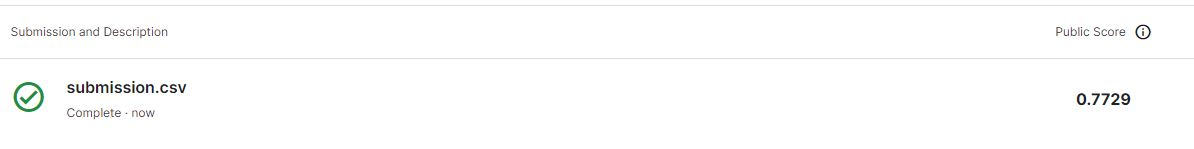

In my Kaggle notebook for the Disaster Tweets NLP challenge, my submission.csv returned a public score of 0.7729.

This is a decent score, but there is still room for improvement. One thing that helped improve the performance of my models was cleaning the text data by removing URLs, and punctuation, as well as converting all text to lowercase.

However, there were also areas where my notebook could be improved. One potential improvement is to experiment with different types of models, such as bidirectional LSTMs or transformers. Another potential improvement is to fine-tune the pre-trained word embeddings on the dataset, which can often lead to better performance.

Overall, my key takeaway from this project is the importance of data cleaning and using pre-trained embeddings to improve the performance of NLP models. I also learned the value of experimenting with different models and techniques to find the best approach for a given dataset.